In [1]:
import sys, io
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import nnls
from fractions import Fraction
import duckdb

In [2]:
with open("collatz_edges.tsv", "r") as f:
    lattice_df = pd.read_csv(f, sep='\t', names=["G", "p_", "q_", "c_", "path", "p", "q", "c", "ln_2_val", "numer", "denom"])

lattice_df

,G,p_,q_,c_,path,p,q,c,ln_2_val,numer,denom
0,1,0,0,0,_1,1,0,0,1.000000,2,1
1,1,0,0,0,_0,1,1,1,-1.584963,1,3
2,2,1,0,0,_11,2,0,0,2.000000,4,1
3,2,1,0,0,_10,2,1,2,-0.584963,2,3
4,2,1,1,1,_01,2,1,1,0.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
33554425,24,23,22,31378962457,_000000000000000000000100,24,23,94145275979,0.000225,-94128498763,94143178827
33554426,24,23,22,31376865305,_000000000000000000000011,24,22,31376865305,0.000964,-31360088089,31381059609
33554427,24,23,22,31376865305,_000000000000000000000010,24,23,94138984523,0.000321,-94122207307,94143178827
33554428,24,23,23,94134790219,_000000000000000000000001,24,23,94134790219,0.000386,-31372671001,31381059609


In [18]:
min_val_per_gen_df = duckdb.query("SELECT G, min( (POWER(2, p) - c)*POWER(3, p-q)) as min_val FROM lattice_df GROUP BY G ORDER BY G")

In [19]:
min_val_per_gen_df

┌───────┬────────────────────────┐
│   G   │        min_val         │
│ int64 │         double         │
├───────┼────────────────────────┤
│     1 │                    1.0 │
│     2 │                   -1.0 │
│     3 │                  -11.0 │
│     4 │                  -66.0 │
│     5 │                 -396.0 │
│     6 │                -2376.0 │
│     7 │               -14256.0 │
│     8 │               -85536.0 │
│     9 │              -513216.0 │
│    10 │             -3079296.0 │
│     · │                  ·     │
│     · │                  ·     │
│     · │                  ·     │
│    15 │         -23944605696.0 │
│    16 │        -143667634176.0 │
│    17 │        -862005805056.0 │
│    18 │       -5172034830336.0 │
│    19 │      -31032208982016.0 │
│    20 │     -186193253892096.0 │
│    21 │    -1117159523352576.0 │
│    22 │    -6702957140115456.0 │
│    23 │ -4.021774284069274e+16 │
│    24 │ -2.413064570441564e+17 │
├───────┴────────────────────────┤
│ 24 rows (20 shown)

In [22]:
for i in range(3, 9, 1):
    print(11 * (6**(i-3))/(3**i))

0.4074074074074074
0.8148148148148148
1.6296296296296295
3.259259259259259
6.518518518518518
13.037037037037036


In [30]:
sql = """SELECT G, min_val, path
FROM (
    SELECT G, ((POWER(2, p) - c)*POWER(3, p-q)) as min_val, path,
           ROW_NUMBER() OVER (PARTITION BY G ORDER BY ((POWER(2, p) - c)*POWER(3, p-q)) ASC) AS rn
    FROM lattice_df
    ORDER BY G
) sub
WHERE rn = 1;
"""


In [31]:
duckdb.query(sql)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────┬────────────────────────┬───────────────────────────┐
│   G   │        min_val         │           path            │
│ int64 │         double         │          varchar          │
├───────┼────────────────────────┼───────────────────────────┤
│     1 │                    1.0 │ _0                        │
│     2 │                   -1.0 │ _00                       │
│     3 │                  -11.0 │ _000                      │
│     4 │                  -66.0 │ _1000                     │
│     5 │                 -396.0 │ _11000                    │
│     6 │                -2376.0 │ _111000                   │
│     7 │               -14256.0 │ _1111000                  │
│     8 │               -85536.0 │ _11111000                 │
│     9 │              -513216.0 │ _111111000                │
│    10 │             -3079296.0 │ _1111111000               │
│     · │                  ·     │      ·                    │
│     · │                  ·     │      ·              

In [3]:
int_df = duckdb.query("SELECT G, path, p, q, c, numer FROM lattice_df WHERE denom == 1").to_df()

In [4]:
int_df

,G,path,p,q,c,numer
0,1,_1,1,0,0,2
1,2,_11,2,0,0,4
2,2,_01,2,1,1,1
3,3,_111,3,0,0,8
4,3,_101,3,1,2,2
...,...,...,...,...,...,...
6147,24,_000101001111111011011101,24,9,5302027,583
6148,24,_000011111011111111011101,24,7,4987099,5391
6149,24,_000011110111010101010101,24,11,14120011,15
6150,24,_000011011100110010110111,24,11,2782603,79


# Integer Distributions across generations

We want to put all integers in buckets by generation to get an idea of how the newly generated integers of each generation are distributed

In [5]:
# Generation 0 is not in the data frame ... so initialize with its values in-place
SEEN = {1:1}
Buckets = {0: {0: [1]}}

def addBucketItem(generation, bucket, val):
    if generation not in Buckets:
        Buckets[generation] = {}
    if bucket not in Buckets[generation]:
        Buckets[generation][bucket] = []
    Buckets[generation][bucket].append(val)
#

def buketize(row):
    val = row["numer"]
    g = row["G"]
    if val in SEEN:
        SEEN[val] += 1
    else:
        bucket = int(math.floor(math.log2(val)))
        addBucketItem(g, bucket, val)
        SEEN[val] = 1
#

int_df.apply(buketize, axis=1)

    

0       None
1       None
2       None
3       None
4       None
        ... 
6147    None
6148    None
6149    None
6150    None
6151    None
Length: 6152, dtype: object

In [6]:
# def countBucketItems():
max_gen = max(Buckets.keys())
max_buckets = max(Buckets[max_gen].keys())

max_gen, max_buckets

(24, 24)

In [7]:
T = np.zeros((max_gen+1, max_buckets+1))

In [8]:
for i in range(max_gen+1):
    if i in Buckets:
        for j in range(max_buckets+1):
            if j in Buckets[i]:
                T[i][j] = len(Buckets[i][j])

In [9]:
T

array([[  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  0.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,  

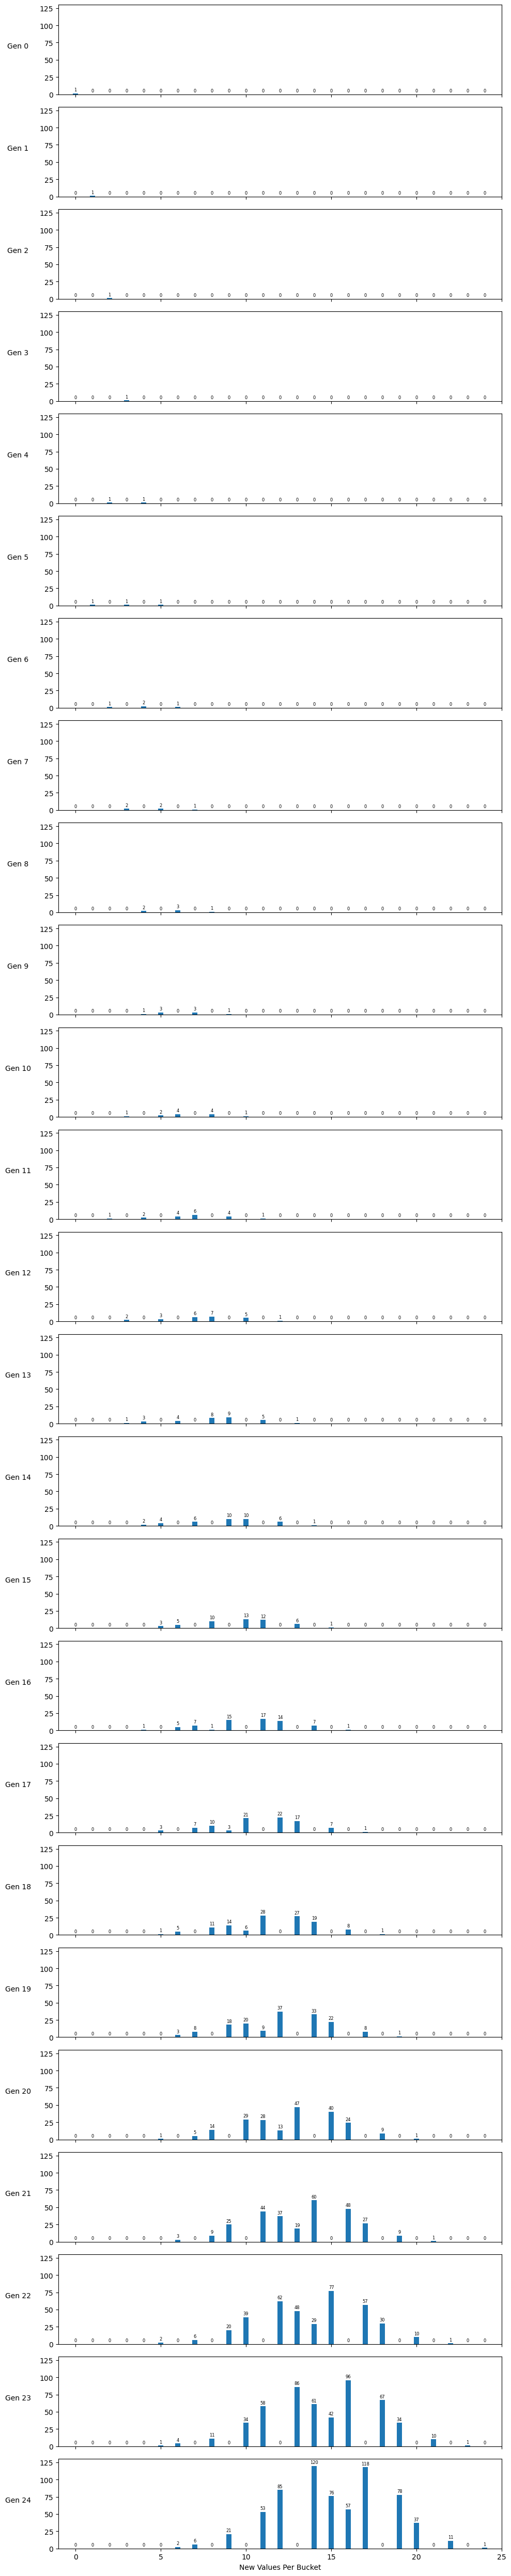

In [10]:

# Create subplots: 25 rows, 1 column
fig, axes = plt.subplots(nrows=25, ncols=1, figsize=(10, 50), sharex=True)

# Plot each row as a thin bar chart in its own subplot
for i in range(25):
    bars = axes[i].bar(range(25), T[i], width=0.3)
    axes[i].set_ylabel(f'Gen {i}', rotation=0, labelpad=30)
    axes[i].set_ylim(0, 130)  
    axes[i].set_xlim(-1, 25)

    for bar in bars:
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,
            height + 2,
            f'{height:.0f}',
            ha='center',
            va='bottom',
            fontsize=6
        )
#

# Set common X-axis label
plt.xlabel('New Values Per Bucket')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [38]:
gen = 5
bucket = 1
Buckets[gen][bucket]

[3]

In [39]:
Buckets[gen+1][bucket+1]

[6]

7 is not in the above and not seen until generation 11 where it seems to start the next sub-distribution

In [40]:
gen = 11
bucket = 2

Buckets[11][2]

[7]

In [41]:
Buckets[gen+1][bucket+1]

[14, 15]

In [29]:
3 not in Buckets[17]

True

In [30]:
for i in range(12, len(Buckets), 1):
    if 3 in Buckets[i]:
        print((i, 3, Buckets[i][3]))


(12, 3, [14, 15])
(13, 3, [9])


In [32]:
for i in range(14, len(Buckets), 1):
    if 4 in Buckets[i]:
        print((i, 4, Buckets[i][4]))

(14, 4, [18, 19])
(16, 4, [25])


In [33]:
for i in range(17, len(Buckets), 1):
    if 5 in Buckets[i]:
        print((i, 5, Buckets[i][5]))

(17, 5, [50, 49, 51])
(18, 5, [33])
(20, 5, [43])
(22, 5, [57, 59])
(23, 5, [39])


# OEIS A092893
https://oeis.org/A092893

1,5,3,17,11,  $7,9,35,33,...$ -- Smallest starting value in a Collatz '3x+1' sequence such that the sequence contains exactly n tripling steps


In [25]:
Buckets[17]

{17: [131072],
 15: [40960, 43008, 43520, 43648, 43680, 43688, 43690],
 13: [12288,
  13312,
  13568,
  14464,
  13632,
  14528,
  14496,
  13648,
  14544,
  14504,
  13652,
  14548,
  14506,
  14562,
  13653,
  14549,
  14563],
 12: [4352,
  4480,
  4416,
  4800,
  4512,
  4832,
  4432,
  4816,
  4520,
  4840,
  4436,
  4820,
  4548,
  4522,
  4842,
  4834,
  4550,
  4437,
  4821,
  4549,
  4849,
  4835],
 10: [1408,
  1472,
  1440,
  1488,
  1448,
  1608,
  1492,
  1476,
  1604,
  1612,
  1450,
  1610,
  1506,
  1478,
  1606,
  1493,
  1477,
  1605,
  1613,
  1507,
  1611],
 8: [448, 480, 464, 488, 468, 490, 482, 469, 497, 483],
 7: [144, 152, 148, 154, 162, 149, 163],
 5: [50, 49, 51],
 9: [534, 537, 535]}

# Observations from the plots

# Expected:
⁍ Highest bucket always has 1 value:  $2^{N}$

⁍ Distribution centered around 3/5 to 3/4 of way across bucket values

⁍ As the generations get larger, the smaller buckets will have fewer values and eventually none. (Can't quite see it) -- but after generation 23, bucket 5 will be zero for all generations but 2 up to generation 71 when the last value of this bucket, 27, is generated.

⁍ Because $1↑2↑4↑8⇅(5,16)$ at most 1/8th of all Collatz Lattices in a generation produce integers. 
    
# Unexpected:
⁍ Second largest bucket of each generation is zero

⁍ Third largest bucket has size $FLOOR(\frac{N-3}{2})$

⁍ The consitently shifting gaps -- Note except for the second highest, the gap buckets will have values that were propagated from generation-2.

⁍ The largest bucket is not consistent across the generations

⁍ From generation 18-on the fourth highest bucket is always zero ... do we pick up more and more of these empty buckets on the right as generations grow?

## Two Distributions
This seems to be a union of 2 distributions.

- Rooted in bucket $[5][1]$ which:
    - Contains Collatz number $5$
    - $5$ has the ROOT Lattice Path '0111' 

- Rooted in bucket $[11][2]$ which:
    - Contains Collatz number $7$
    - $7$ has Lattice Path '00010110111'
    - '0001011' is 55/81 or 330/729
    - The Collatz Path for 7 includes 5 -- was expecting the two distributions to be rooted at 5 and 8 or 5 and 256 ... not 5 and 7

- Suspect there are more
    - Any bucket on the far left or right will spawn a new binary tree, but especially for the left, it may take a while for it to really appear as a contributor to the integers.
 
Because these distributions are based on the Collatz Values and NOT the Collatz Paths, they may give us a new orthogonal view of the problem.

# How many generations to fill in all numbers less than $2^7$?

If it takes 71 generations to fill all numbers less than $2^5$, then how many does it take to fill in all numbers less than $2^7$ ?

The answer is just $75$ generations ... not exponentially larger than the generation to fill in the numbers below 32.

# So how about $2^9$ then?

    $2^{N}$

In [11]:
Buckets[i][j]

[16777216]

In [12]:
Buckets[2]

{2: [4]}

In [13]:
for i in range(4, 25):
    print(Buckets[i][i-2])

[5]
[10]
[20, 21]
[40, 42]
[80, 84, 85]
[160, 168, 170]
[320, 336, 340, 341]
[640, 672, 680, 682]
[1280, 1344, 1360, 1364, 1365]
[2560, 2688, 2720, 2728, 2730]
[5120, 5376, 5440, 5456, 5460, 5461]
[10240, 10752, 10880, 10912, 10920, 10922]
[20480, 21504, 21760, 21824, 21840, 21844, 21845]
[40960, 43008, 43520, 43648, 43680, 43688, 43690]
[81920, 86016, 87040, 87296, 87360, 87376, 87380, 87381]
[163840, 172032, 174080, 174592, 174720, 174752, 174760, 174762]
[327680, 344064, 348160, 349184, 349440, 349504, 349520, 349524, 349525]
[655360, 688128, 696320, 698368, 698880, 699008, 699040, 699048, 699050]
[1310720, 1376256, 1392640, 1396736, 1397760, 1398016, 1398080, 1398096, 1398100, 1398101]
[2621440, 2752512, 2785280, 2793472, 2795520, 2796032, 2796160, 2796192, 2796200, 2796202]
[5242880, 5505024, 5570560, 5586944, 5591040, 5592064, 5592320, 5592384, 5592400, 5592404, 5592405]


# Numbral Arithmetic

The last numbers from generations 4,6,8, etc. are:

$5,21,85,341,1365 \rightarrow OEIS A002450 \ \ $  https://oeis.org/A002450

Above sequence is described as *"For n > 0, a(n) is the degree (n-1) "numbral" power of 5"*

$ 5 = 101_b,\ 21 = 10101_b,\ 65 = 1010101_b,\ ... $

So $ 2^2 + 2^0, \ 2^4 + 2^2 + 2^0,\ 2^6 + 2^4 + 2^2 + 2^0,\ ... $

## Numbral Arithmetic Definition

Definition from https://oeis.org/A048888 

Define a "numbral arithmetic" by 

⁍ replacing addition with binary bitwise inclusive-OR (so that [3] + [5] = [7] etc.)

⁍ multiplication becomes shift-&-OR instead of shift-&-add (so that [3] * [3] = [7] etc.). 

⁍ [d] divides [n] means there exists an [e] with [d] * [e] = [n]. For example the six divisors of [14] are [1], [2], [3], [6], [7] and [14]. 

⁍ Then it appears that this sequence gives the number of proper divisors of [2^n-1]. 

⁍⁍ Conjecture confirmed by Richard C. Schroeppel, Dec 14 2001. (End)

In [14]:
# The 5th, 6th, 7th, ... buckets starting with generation 20
# One example of leftish-bucket lower numbers being filled in by higher generations
for i in range(20, 25, 1):
    print(Buckets[i][i-15])

[43]
[86, 89, 87]
[172, 178, 174, 173, 177, 179]
[344, 356, 348, 346, 354, 358, 357, 349, 385, 355, 423]
[688, 712, 696, 692, 708, 716, 714, 698, 770, 710, 846, 693, 709, 717, 705, 769, 729, 761, 777, 771, 847]


In [15]:
# The 5th, 6th, 7th, ... buckets starting with generation 10
# Center-to-right buckets filled in from higher generations
for i in range(10, 16, 1):
    print(Buckets[i][i-5])

[34, 35]
[68, 70, 69, 75]
[136, 140, 138, 150, 141, 151]
[272, 280, 276, 300, 282, 302, 277, 301]
[544, 560, 552, 600, 564, 604, 554, 602, 565, 605]
[1088, 1120, 1104, 1200, 1128, 1208, 1108, 1204, 1130, 1210, 1109, 1205, 1137]


What is so special about generation 70?

It produces the last missing element, 27, of bucket 4.  The humps will be centered around bucket 53 or so and a good fraction of buckets below 25 will be zero ... right?

In [18]:
for i in range(11, 25):
    print(Buckets[i][i-9])

[7]
[14, 15]
[28, 30, 29]
[56, 60, 58, 61]
[112, 120, 116, 122, 117]
[224, 240, 232, 244, 234, 245, 241]
[448, 480, 464, 488, 468, 490, 482, 469, 497, 483]
[896, 960, 928, 976, 936, 980, 964, 938, 994, 966, 981, 965, 985, 995]
[1792, 1920, 1856, 1952, 1872, 1960, 1928, 1876, 1988, 1932, 1962, 1930, 1970, 1990, 1877, 1989, 1933, 1969, 2009, 1971]
[3584, 3840, 3712, 3904, 3744, 3920, 3856, 3752, 3976, 3864, 3924, 3860, 3940, 3980, 3754, 3978, 3866, 3938, 4018, 3942, 3925, 3861, 3941, 3981, 4017, 3939, 4019, 4043]
[7168, 7680, 7424, 7808, 7488, 7840, 7712, 7504, 7952, 7728, 7848, 7720, 7880, 7960, 7508, 7956, 7732, 7876, 8036, 7884, 7850, 7722, 7882, 7962, 8034, 7878, 8038, 8086, 7509, 7957, 7733, 7877, 8037, 7885, 8089, 8035, 8087]
[14336, 15360, 14848, 15616, 14976, 15680, 15424, 15008, 15904, 15456, 15696, 15440, 15760, 15920, 15016, 15912, 15464, 15752, 16072, 15768, 15700, 15444, 15764, 15924, 16068, 15756, 16076, 16172, 15018, 15914, 15466, 15754, 16074, 15770, 16178, 16070, 16174, 